In [0]:
!pip install transformers

     |████████████████████████████████| 552kB 13.9MB/s 
     |████████████████████████████████| 870kB 22.4MB/s 
     |████████████████████████████████| 3.7MB 65.0MB/s 
     |████████████████████████████████| 1.0MB 64.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=63f8f5ed0d34853fcd641c0826d332118eaad68d049935b60e6b9e2ea59be772
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))
# Edit > Notebook Settings > Put on a GPU 

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# read in the sets! 

X_train = pd.read_csv('/content/drive/My Drive/Vaccine Capstone/Labelled Dataset/Datasets_XLNet/0402_X_TRAIN.csv')
X_test = pd.read_csv('/content/drive/My Drive/Vaccine Capstone/Labelled Dataset/Datasets_XLNet/0402_X_TEST.csv')

In [0]:
# ensure that the hash_processed columns are all strings 
#comb_df['hash_processed'] = list(map(str, comb_df['hash_processed']))
X_train['hash_processed'] = list(map(str, X_train['hash_processed'])) 
X_test['hash_processed'] = list(map(str, X_test['hash_processed']))

In [0]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [0]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [0]:
train_text_list = X_train["hash_processed"].values #note the change here
test_text_list = X_test["hash_processed"].values #note the change here

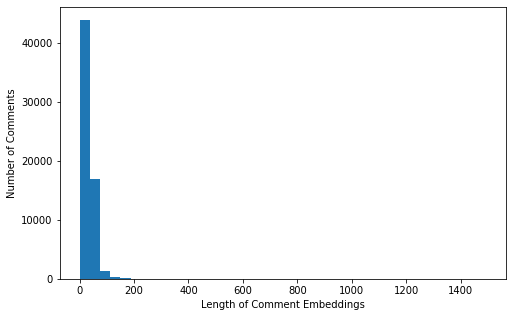

In [0]:
plot_sentence_embeddings_length(train_text_list, tokenizer) 

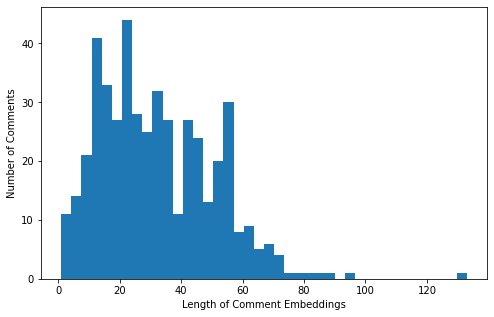

In [0]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [0]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

In [0]:
def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [0]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[19723,  3685,    20, ...,     0,     0,     0],
       [   39,  3676,    20, ...,     0,     0,     0],
       [  112,    44,   343, ...,     0,     0,     0],
       ...,
       [   17,   150,    64, ...,     0,     0,     0],
       [19583,    41,  1686, ...,     0,     0,     0],
       [  739,  1445,    40, ...,     0,     0,     0]])

In [0]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[   18,  3945, 24673, ...,     0,     0,     0],
       [ 3132,    18,  3778, ...,     0,     0,     0],
       [   17,   150,   112, ...,     0,     0,     0],
       ...,
       [   63,    41,   381, ...,     0,     0,     0],
       [   65,    20,    94, ...,     0,     0,     0],
       [19583,    41, 25957, ...,     0,     0,     0]])

In [0]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)

In [0]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)

In [0]:
# add input ids and attention masks to the dataframe
X_train["features"] = train_input_ids.tolist()
X_train["masks"] = train_attention_masks

X_test["features"] = test_input_ids.tolist()
X_test["masks"] = test_attention_masks

In [0]:
# train valid split
train, valid = train_test_split(X_train, test_size=0.2, random_state=42)

In [0]:
X_train_final = train["features"].values.tolist()
X_valid_final = valid["features"].values.tolist()

X_train_masks = train["masks"].values.tolist()
X_valid_masks = valid["masks"].values.tolist()

label_cols = ['Conspiracy: Distrust of government, organizations, big pharma',
       'Fear of Critical side-effects (Autism, Brain Damage, SIDS/Death)',
       'Fear of Non-critical side-effects (Rash, Pain, Fever, GI problems, Bump on arm)',
       'Holistic or alternative medicine', 'Logistic Concerns', 'Pro-vax', 'Religious Beliefs',
       'Right to choose',
       'Toxic Ingredients, unclear origins of materials/manufacturer',
       'Vaccines ineffective/unnecessary']
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [0]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train_final = torch.tensor(X_train_final)
X_valid_final = torch.tensor(X_valid_final)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

X_train_masks = torch.tensor(X_train_masks, dtype=torch.long)
X_valid_masks = torch.tensor(X_valid_masks, dtype=torch.long)

In [0]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train_final, X_train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid_final, X_valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [0]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [0]:
torch.cuda.empty_cache()

In [0]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

In [0]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [0]:
num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/My Drive/Vaccine Capstone/Labelled Dataset/Datasets_XLNet/xlnet_hashp_hamming0402.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.0041961200764249005
Valid loss: 0.0008474527080532763


Epoch:  33%|███▎      | 1/3 [1:10:13<2:20:26, 4213.34s/it]

Saving model at epoch 0 with validation loss of 0.0008474527080532763


Train loss: 0.0007253852408337539
Valid loss: 0.0003989986928689132


Epoch:  67%|██████▋   | 2/3 [2:20:29<1:10:14, 4214.30s/it]

Saving model at epoch 1 with validation loss of 0.0003989986928689132


Train loss: 0.00030069931207863076
Valid loss: 0.00026767839400250313


Epoch: 100%|██████████| 3/3 [3:30:43<00:00, 4214.55s/it]

Saving model at epoch 2 with validation loss of 0.00026767839400250313




Text(0.5, 1.0, 'Loss vs Number of Epochs')

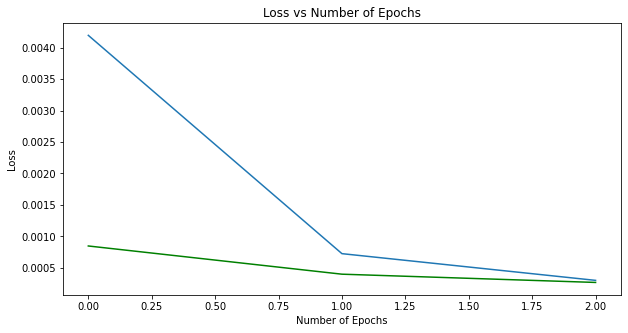

In [0]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [0]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [0]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, X_test, num_labels, device="cuda", batch_size=32)


In [0]:
# make copy of X_test_full 
X_test_pred=X_test[['aug_data','cluster_number','tweet','hash_processed']].copy(deep=True)
pred_probs_round = np.round(pred_probs)
X_test_pred['Conspiracy: Distrust of government, organizations, big pharma']=pred_probs_round[:,0]
X_test_pred['Fear of Critical side-effects (Autism, Brain Damage, SIDS/Death)']=pred_probs_round[:,1]
X_test_pred['Fear of Non-critical side-effects (Rash, Pain, Fever, GI problems, Bump on arm)']=pred_probs_round[:,2]
X_test_pred['Holistic or alternative medicine']=pred_probs_round[:,3]
X_test_pred['Logistic Concerns']=pred_probs_round[:,4] 
X_test_pred['Pro-vax']=pred_probs_round[:,5] 
X_test_pred['Religious Beliefs']=pred_probs_round[:,6]
X_test_pred['Right to choose']=pred_probs_round[:,7] 
X_test_pred['Toxic Ingredients, unclear origins of materials/manufacturer']=pred_probs_round[:,8] 
X_test_pred['Vaccines ineffective/unnecessary']=pred_probs_round[:,9]

In [0]:
# hamming distance on test set 

In [0]:
columns_to_view = ['Conspiracy: Distrust of government, organizations, big pharma',
       'Fear of Critical side-effects (Autism, Brain Damage, SIDS/Death)',
       'Fear of Non-critical side-effects (Rash, Pain, Fever, GI problems, Bump on arm)',
       'Holistic or alternative medicine', 'Logistic Concerns', 'Pro-vax', 'Religious Beliefs',
       'Right to choose',
       'Toxic Ingredients, unclear origins of materials/manufacturer',
       'Vaccines ineffective/unnecessary']

from scipy.spatial import distance

In [0]:
y_test_pred = [] #holds predictions for X_test 
for index, row in X_test_pred[columns_to_view].iterrows(): 
	y_test_pred.append(list(row.values))

# append onto X_test
X_test['pred'] = y_test_pred

In [0]:
y_test_truth = [] #holds truth for X_test 
for index, row in X_test[columns_to_view].iterrows(): 
	y_test_truth.append(list(row.values))

# append onto X_test
X_test['truth'] = y_test_truth

In [0]:
y_test_compare = pd.concat([pd.Series(y_test_pred), pd.Series(y_test_truth)], axis=1)
y_test_compare.columns = ['pred','actual'] 
y_test_compare['hamming'] = y_test_compare.apply(lambda x: distance.hamming(x['pred'],x['actual']), axis=1)

X_test['hamming'] = y_test_compare['hamming'] 

In [0]:
X_test.head(5)

,aug_data,cluster_number,tweet,hash_processed,"Conspiracy: Distrust of government, organizations, big pharma","Fear of Critical side-effects (Autism, Brain Damage, SIDS/Death)","Fear of Non-critical side-effects (Rash, Pain, Fever, GI problems, Bump on arm)",Holistic or alternative medicine,Logistic Concerns,Pro-vax,Religious Beliefs,Right to choose,"Toxic Ingredients, unclear origins of materials/manufacturer",Vaccines ineffective/unnecessary,features,masks,pred,truth,hamming
0,1.0,4,The deaths/neurological damage done to #childr...,the deathsneurological anula damage done to ch...,0,1,0,0,0,0,0,0,0,0,"[18, 3945, 24673, 4010, 48, 3879, 1696, 588, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
1,1.0,22,Guess the flu shot isnt quite helping. Feel li...,guess the flu shot isnt quite helping 've like...,0,0,1,0,0,0,0,0,0,0,"[3132, 18, 3778, 938, 1601, 46, 1206, 2331, 17...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0.0
2,1.0,22,@nappySOLflower 1. I don't take medicine. If i...,i do not take medicine if it is not natural fl...,0,0,0,1,0,0,0,0,0,0,"[17, 150, 112, 50, 182, 3301, 108, 36, 27, 50,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",0.0
3,1.0,2,Risk still exists. No vaccine outcome can be p...,risk still exists no cdc outcome can be predic...,0,1,0,0,0,0,0,0,0,0,"[1046, 194, 5904, 116, 2349, 66, 369, 5201, 64...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
4,0.0,23,Money and public health,money and public health,1,0,0,0,0,0,0,0,0,0,"[356, 21, 281, 454, 4, 3, 0, 0, 0, 0, 0, 0, 0,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.2


In [0]:
np.nanmean(X_test['hamming'])


0.014775160599571735

In [0]:
np.nanstd(X_test['hamming'])

0.046460394864089344

In [0]:
X_test.to_csv('/content/drive/My Drive/Vaccine Capstone/Labelled Dataset/Datasets_XLNet/0402_Xtest_withhamming.csv', index=False)

In [0]:
# hamming distance on valid set 

# make predictions first on the validation set
pred_probs_valid = generate_predictions(model, valid, num_labels, device="cuda", batch_size=32)

In [0]:
X_valid_pred=valid[['aug_data','cluster_number','tweet','hash_processed']].copy(deep=True)
pred_probs_valid_round = np.round(pred_probs_valid)

In [0]:
X_valid_pred['Conspiracy: Distrust of government, organizations, big pharma']=pred_probs_valid_round[:,0]
X_valid_pred['Fear of Critical side-effects (Autism, Brain Damage, SIDS/Death)']=pred_probs_valid_round[:,1]
X_valid_pred['Fear of Non-critical side-effects (Rash, Pain, Fever, GI problems, Bump on arm)']=pred_probs_valid_round[:,2]
X_valid_pred['Holistic or alternative medicine']=pred_probs_valid_round[:,3]
X_valid_pred['Logistic Concerns']=pred_probs_valid_round[:,4] 
X_valid_pred['Pro-vax']=pred_probs_valid_round[:,5] 
X_valid_pred['Religious Beliefs']=pred_probs_valid_round[:,6]
X_valid_pred['Right to choose']=pred_probs_valid_round[:,7] 
X_valid_pred['Toxic Ingredients, unclear origins of materials/manufacturer']=pred_probs_valid_round[:,8] 
X_valid_pred['Vaccines ineffective/unnecessary']=pred_probs_valid_round[:,9]


In [0]:
y_valid_pred = [] #holds predictions for valid
for index, row in X_valid_pred[columns_to_view].iterrows(): 
	y_valid_pred.append(list(row.values))

# append onto valid
valid['pred'] = y_valid_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
y_valid_truth = [] #holds truth for valid
for index, row in valid[columns_to_view].iterrows(): 
    y_valid_truth.append(list(row.values))

# append onto valid 
valid['truth'] = y_valid_truth

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
y_valid_compare = pd.concat([pd.Series(y_valid_pred), pd.Series(y_valid_truth)], axis=1)
y_valid_compare.columns = ['pred','actual'] 
y_valid_compare['hamming'] = y_valid_compare.apply(lambda x: distance.hamming(x['pred'],x['actual']), axis=1)

valid['hamming'] = y_valid_compare['hamming'] 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
y_valid_compare['hamming'].values

array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
len(valid)

12493

In [0]:
valid['hamming']=list(y_valid_compare['hamming'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
valid.head()

,aug_data,cluster_number,tweet,hash_processed,"Conspiracy: Distrust of government, organizations, big pharma","Fear of Critical side-effects (Autism, Brain Damage, SIDS/Death)","Fear of Non-critical side-effects (Rash, Pain, Fever, GI problems, Bump on arm)",Holistic or alternative medicine,Logistic Concerns,Pro-vax,Religious Beliefs,Right to choose,"Toxic Ingredients, unclear origins of materials/manufacturer",Vaccines ineffective/unnecessary,features,masks,pred,truth,hamming
27119,1.0,4,Don't talk about women's rights to me don't te...,dont talk about womens rights to look do not t...,0,0,0,0,0,0,0,1,0,0,"[220, 46, 1034, 75, 412, 23, 776, 22, 338, 112...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",0.0
51662,0.0,4,New York becomes the fifth state to eliminate ...,new york becomes the fifth state to eliminate ...,0,0,0,0,0,1,0,0,0,0,"[109, 24512, 2768, 18, 2287, 204, 22, 5614, 17...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0.0
33835,1.0,2,"""If you believe in vaccination for ""the greate...",if you believe in vaccination for the greater ...,0,1,0,0,0,0,0,0,0,0,"[108, 44, 676, 25, 19507, 28, 18, 1786, 17, 14...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
6145,1.0,23,They encourage it to protect everyone possible...,they encourage it to protect everyone suggest ...,0,0,0,0,0,1,0,0,0,0,"[63, 3637, 36, 22, 1539, 1251, 3179, 25, 1814,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0.0
14813,1.0,25,Because their puppet-masters make a BUNCH of m...,because their puppetmasters make a bunch of fe...,1,0,0,0,0,0,0,0,0,0,"[149, 58, 17301, 6339, 23, 144, 24, 7353, 20, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0


In [0]:
np.nanmean(valid['hamming'])

0.0026574881933882975

In [0]:
np.nanstd(valid['hamming'])

0.020424870367835996

In [0]:
valid.to_csv('/content/drive/My Drive/Vaccine Capstone/Labelled Dataset/Datasets_XLNet/0402_Xvalid_withhamming.csv', index=False)

In [0]:
len(X_test[X_test['pred']==X_test['truth']]) #418/467 so roughly 89% we could match from test set 

418

In [0]:
len(X_test)

467

In [0]:
len(X_test[X_test['pred']!=X_test['truth']])

49

In [0]:
X_test[X_test['pred']==X_test['truth']].groupby('cluster_number').count()['hash_processed']
# for all the ones we did match exactly: 
# clusters 1 through 9 are polio 
# cluster 22 = flu 
# cluster 23,24,25 = survey responses 
# 121 out of the 418 were survey responses 

cluster_number
1      10
2      62
3       9
4     109
7      10
9      16
22     81
23     45
24     37
25     39
Name: hash_processed, dtype: int64

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [0]:
X_test[X_test['pred']!=X_test['truth']].groupby('cluster_number').count()['hash_processed']
# for the ones we got wrong 
# 22+10+10 = 42 out of the 49 we got wrong were survey responses 

cluster_number
2      1
4      5
9      1
23    22
24    10
25    10
Name: hash_processed, dtype: int64

In [0]:
np.max(X_test['hamming'])

0.3

In [0]:
X_test.sort_values(by='hamming', ascending=False)

,aug_data,cluster_number,tweet,hash_processed,"Conspiracy: Distrust of government, organizations, big pharma","Fear of Critical side-effects (Autism, Brain Damage, SIDS/Death)","Fear of Non-critical side-effects (Rash, Pain, Fever, GI problems, Bump on arm)",Holistic or alternative medicine,Logistic Concerns,Pro-vax,Religious Beliefs,Right to choose,"Toxic Ingredients, unclear origins of materials/manufacturer",Vaccines ineffective/unnecessary,features,masks,pred,truth,hamming
130,0.0,23,"I think in the majority of cases, most people ...",i think in the majority of cases most people i...,1,0,0,0,0,0,0,0,1,0,"[17, 150, 232, 25, 18, 1472, 20, 1057, 127, 10...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]",0.3
372,0.0,24,I understand why people don't trust the govern...,i understand why people do not trust the gover...,1,0,0,0,0,0,0,0,0,0,"[17, 150, 1111, 611, 104, 112, 50, 2269, 18, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.2
27,0.0,25,I consider them safe. The concerns I have are ...,i consider them safe the concerns i have are a...,0,0,1,0,0,1,0,0,0,0,"[17, 150, 1524, 107, 1686, 18, 2011, 17, 150, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0]",0.2
377,0.0,4,Mr stupid dr health is the responsibility of s...,mr stupid dr health is the responsibility of s...,0,0,0,0,0,1,0,0,0,0,"[17, 98, 213, 6179, 17, 7841, 454, 27, 18, 199...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0.2
62,0.0,23,"I do think they're safe for the most part, alt...",i do think they are safe for the most part alt...,0,0,0,0,1,0,0,0,0,0,"[17, 150, 112, 232, 63, 41, 1686, 28, 18, 127,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,1.0,4,“Taking out Bin Laden” involved a covert DNA c...,simply out bin laden involved a covert dna con...,1,0,0,0,0,0,0,0,0,0,"[1172, 78, 4599, 17, 16919, 899, 24, 1263, 46,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
161,0.0,24,I think for the most part vaccines are safe. T...,i think for the most part vaccines are safe th...,0,1,0,0,0,1,0,0,0,0,"[17, 150, 232, 28, 18, 127, 188, 19583, 41, 16...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]",0.0
160,0.0,1,"Anti-vaccination people are dangerous idiots, ...",antivaccination people are dangerous idiots un...,0,0,0,0,0,1,0,0,0,0,"[932, 11176, 6650, 773, 104, 41, 2923, 15118, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0.0
159,0.0,23,"I find the benefits to be obvious, but prevent...",i find the benefits to be obvious but preventi...,0,0,0,0,0,1,0,0,0,0,"[17, 150, 278, 18, 1724, 22, 39, 4079, 57, 860...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0.0


In [1]:
###########
### Error analysis 
###########


import pandas as pd 
import numpy as np 

from google.colab import drive
drive.mount('/content/drive')





Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
testset = pd.read_csv('/content/drive/My Drive/Vaccine Capstone/Labelled Dataset/Datasets_XLNet/0402_Xtest_withhamming.csv', 
                      converters={'pred': eval, 'truth': eval})

In [0]:
validset = pd.read_csv('/content/drive/My Drive/Vaccine Capstone/Labelled Dataset/Datasets_XLNet/0402_Xvalid_withhamming.csv', 
                      converters={'pred': eval, 'truth': eval})

In [4]:
len(testset[testset['pred']==testset['truth']])/len(testset) #total testset = 467

0.8950749464668094

In [5]:
len(testset[testset['pred']==testset['truth']])

418

In [6]:
len(validset[validset['pred']==validset['truth']])/len(validset) #total validationset = 12,493 

0.9812695109261186

In [7]:
len(validset[validset['pred']==validset['truth']])

12259

In [8]:
# max number of labels predicted 
np.nanmax(testset.apply(lambda x: np.nansum(x['pred']), axis=1)) #max of 2 labels 

2.0

In [9]:
# max number of labels predicted in validation set 
np.nanmax(validset.apply(lambda x: np.nansum(x['pred']), axis=1)) #max of 3 labels in validation set 

3.0

In [10]:
# average hamming distance for testset 
np.nanmean(testset['hamming'])

0.014775160599571735

In [11]:
# standard deviation hamming distance 
np.nanstd(testset['hamming'])

0.046460394864089344

In [12]:
np.nanmean(validset['hamming'])

0.0026574881933882975

In [13]:
np.nanstd(validset['hamming'])

0.020424870367835996

In [0]:
toview = ['Conspiracy: Distrust of government, organizations, big pharma',
       'Fear of Critical side-effects (Autism, Brain Damage, SIDS/Death)',
       'Fear of Non-critical side-effects (Rash, Pain, Fever, GI problems, Bump on arm)',
       'Holistic or alternative medicine', 'Logistic Concerns', 'Pro-vax', 'Religious Beliefs',
       'Right to choose',
       'Toxic Ingredients, unclear origins of materials/manufacturer',
       'Vaccines ineffective/unnecessary']

In [15]:
len(toview)

10

In [16]:
len(testset['pred'][0])

10

In [17]:
for index, row in testset.iterrows(): 
  if row['pred']!=row['truth']: 
    print('Index: '+str(index))
    print('---------------------')
    print('Cluster: '+str(row['cluster_number']))
    print('---------------------')
    print('Text: '+row['tweet'])
    print('---------------------')
    print('Hash processed: '+row['hash_processed'])
    print('---------------------')
    grab = row[toview]
    if row['truth']==0: 
      print('True label: Not Relevant')
      print('---------------------')
    else:
      print('True label: ') 
      print(grab[grab>0])
      print('---------------------')
    # get the predicted labels 
    dict_pred = {}
    for i in range(0, len(row['pred'])): 
      dict_pred[toview[i]]=row['pred'][i]
    df_pred = pd.DataFrame(pd.Series(dict_pred))
    df_pred.columns = ['indicator'] 
    print('Predicted as: ')
    print(df_pred[df_pred['indicator']>0].index)
    print('======================================================================')

Index: 4
---------------------
Cluster: 23
---------------------
Text: Money and public health 
---------------------
Hash processed: money and public health
---------------------
True label: 
Conspiracy: Distrust of government, organizations, big pharma    1
Name: 4, dtype: object
---------------------
Predicted as: 
Index(['Pro-vax'], dtype='object')
Index: 27
---------------------
Cluster: 25
---------------------
Text: I consider them safe. The concerns I have are about how they are administered as I usually get really severe arm pain after
---------------------
Hash processed: i consider them safe the concerns i have are about how they are administered as i usually get really severe arm pain after
---------------------
True label: 
Fear of Non-critical side-effects (Rash, Pain, Fever, GI problems, Bump on arm)    1
Pro-vax                                                                            1
Name: 27, dtype: object
---------------------
Predicted as: 
Index(['Logistic Conce

In [29]:
for index, row in testset[testset['pred']==testset['truth']].iterrows(): 
  if row['pred']==row['truth']: 
    print('Index: '+str(index))
    print('---------------------')
    print('Cluster: '+str(row['cluster_number']))
    print('---------------------')
    print('Text: '+row['tweet'])
    print('---------------------')
    print('Hash processed: '+row['hash_processed'])
    print('---------------------')
    grab = row[toview]
    if row['truth']==0: 
      print('True label: Not Relevant')
      print('---------------------')
    else:
      print('True label: ') 
      print(grab[grab>0])
      print('---------------------')
    # get the predicted labels 
    dict_pred = {}
    for i in range(0, len(row['pred'])): 
      dict_pred[toview[i]]=row['pred'][i]
    df_pred = pd.DataFrame(pd.Series(dict_pred))
    df_pred.columns = ['indicator'] 
    print('Predicted as: ')
    print(df_pred[df_pred['indicator']>0].index)
    print('======================================================================')

Streaming output truncated to the last 5000 lines.
Index: 97
---------------------
Cluster: 23
---------------------
Text: Yes, vaccines are safe. The chance of dying from the diseases you can get outweigh the possible complications from vaccinations. 
---------------------
Hash processed: yes vaccines are safe the chance of dying from the diseases you can get outweigh the possible complications from vaccinations
---------------------
True label: 
Pro-vax    1
Name: 97, dtype: object
---------------------
Predicted as: 
Index(['Pro-vax'], dtype='object')
Index: 99
---------------------
Cluster: 2
---------------------
Text: Given you donâ€™t believe adverse events of vaccination exist, I am not at all surprised   Because, your point-of-view   Was MY  point-of-view (and EVERY EX-VAXXERâ€™s);  Until our children were severely, irreversibly & undeniably vaccine injured into death/disability/chronic illness
---------------------
Hash processed: given you dont believe adverse events of vacc

In [0]:
X_train = pd.read_csv('/content/drive/My Drive/Vaccine Capstone/Labelled Dataset/Datasets_XLNet/0402_X_TRAIN.csv')

In [0]:
len(X_train)

62462

In [0]:
X_train.groupby('cluster_number').count()['aug_data']

cluster_number
1       794
2      5789
3       654
4     10218
7      1191
9      1085
22    10359
23    13483
24     9451
25     9438
Name: aug_data, dtype: int64

In [0]:
testset.groupby('cluster_number').count()

,aug_data,tweet,hash_processed,"Conspiracy: Distrust of government, organizations, big pharma","Fear of Critical side-effects (Autism, Brain Damage, SIDS/Death)","Fear of Non-critical side-effects (Rash, Pain, Fever, GI problems, Bump on arm)",Holistic or alternative medicine,Logistic Concerns,Pro-vax,Religious Beliefs,Right to choose,"Toxic Ingredients, unclear origins of materials/manufacturer",Vaccines ineffective/unnecessary,features,masks,pred,truth,hamming
cluster_number,,,,,,,,,,,,,,,,,,
1,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
2,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63
3,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
4,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114
7,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
9,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
22,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81
23,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67
24,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47


In [0]:
67+47+49

163